<a href="https://colab.research.google.com/github/ParmeetChanne/Analysing-Economic-Factors-Python/blob/main/Python_Economic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fredapi > /dev/null

##Importing and setting up the api

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.options.display.max_rows = 500
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

#fred_key = 'put_your_key_here'

#Creating the fred object
fred = Fred(api_key=fred_key)

##Searching for economic data

In [11]:
#Searching for S%P 500 and getting the first 5 results

sp_search = fred.search('S&P', order_by='popularity')
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-12-22,2023-12-22,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-12-21,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-12-22 07:46:02-06:00,93,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-12-22,2023-12-22,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-09-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-11-28 08:12:02-06:00,87,"For more information regarding the index, plea..."
SP500,SP500,2023-12-22,2023-12-22,S&P 500,2013-12-23,2023-12-21,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-12-21 19:10:58-06:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-12-22,2023-12-22,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-12-21,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-12-22 07:46:05-06:00,83,This data represents the effective yield of th...
MEHOINUSA672N,MEHOINUSA672N,2023-12-22,2023-12-22,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,82,Household data are collected as of March. As ...


##Pulling raw data and plotting it

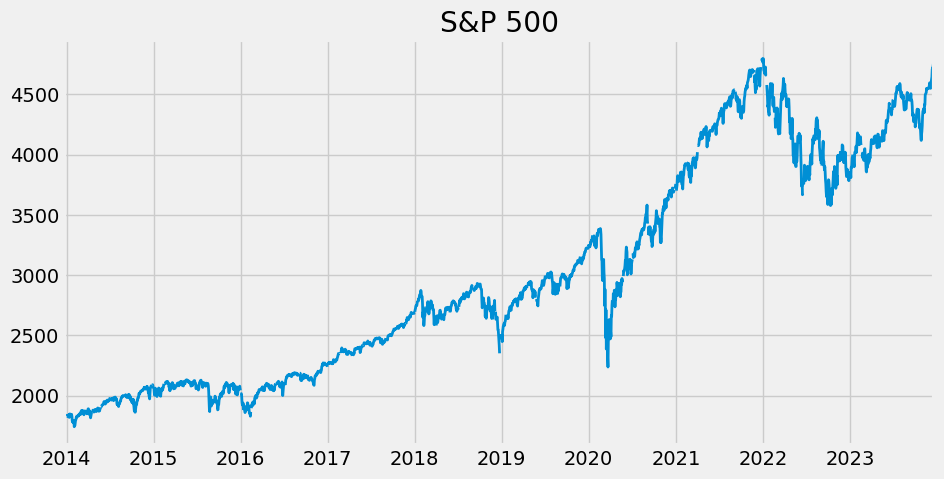

In [12]:
#Getting data and refining the graph to look cleaner

sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

##Pulling and joining multiple data series

In [14]:
#Using unemployment data

#Returning just monthly unemployment rate
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))

#Pulling only seasonally adjusted data
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

#Filtering data to only give the ones which contain unemployment rate
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [16]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)
uemp_results = pd.concat(all_results, axis=1)

In [17]:
#dropping the columns will null values

cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)
uemp_states = uemp_results.copy()
uemp_states = uemp_states.dropna()

In [18]:
#Getting the actual state names from the given data rather than acronyms
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [19]:
#Plotting the data using plotly
px.line(uemp_states)

##Pulling April 2020 Unemployment rate of each state for comparison
April 2020 was right after the lockdown was announced, so comparing and contrasting unemployment data from different states can be constructive in recognizing trends and factors of the respective states.

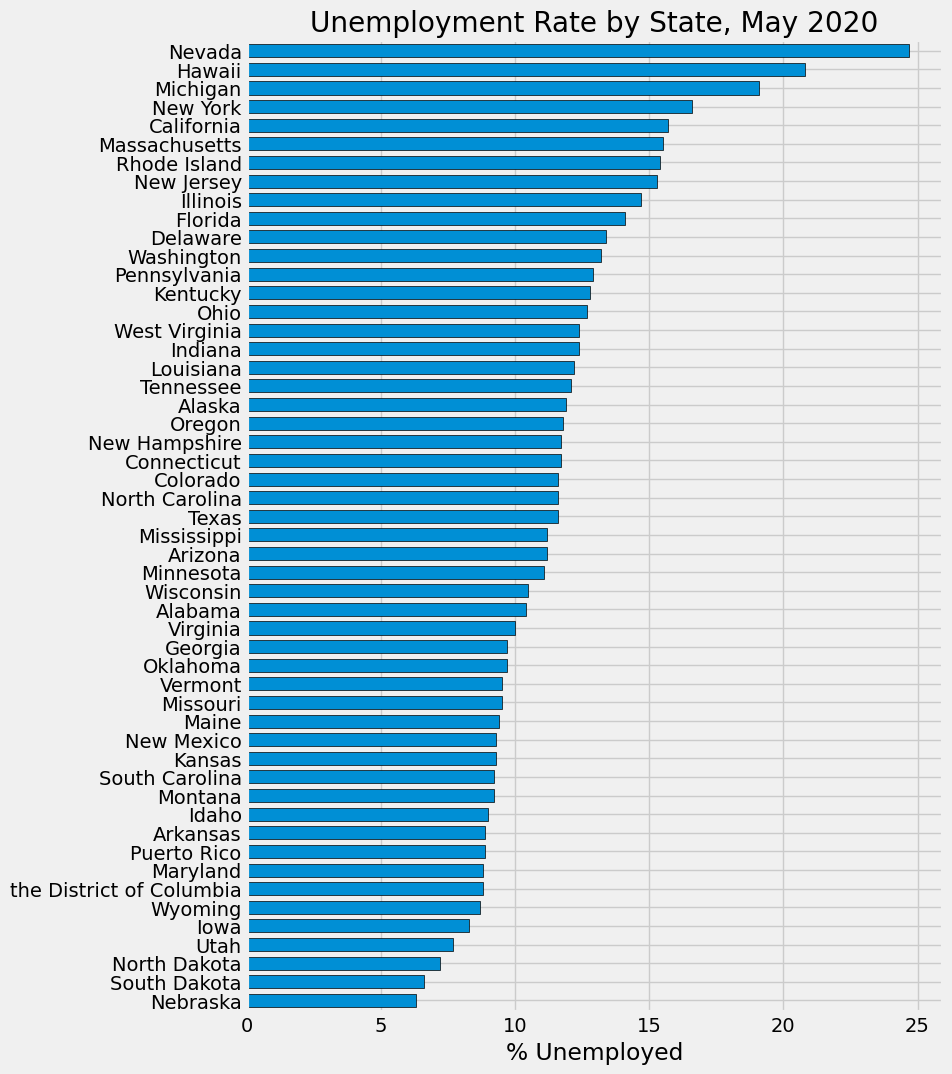

In [22]:
#Creating a bar graph to represent the data

ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

##Pulling participation rate
Participation rate is also a crucial economic factor, so we'll pull that data and try to compare and contrast it with the unemployment data of each state.

In [23]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [24]:
#Again, converting acronyms to complete state names, and repeating the exact process done for unemployment data

part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

##Plotting Unemployment against Participation for all states
Between 2020 and 2021

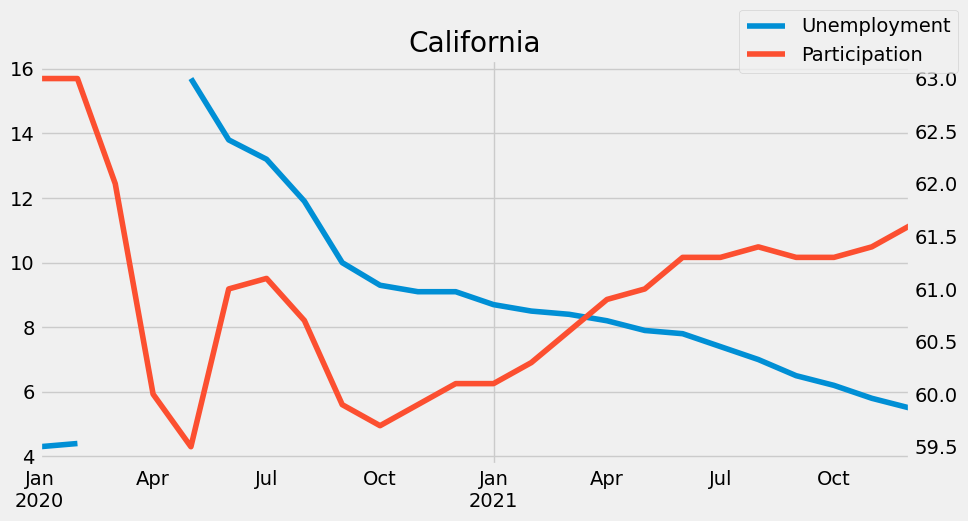

In [29]:
# For a single state:

state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()

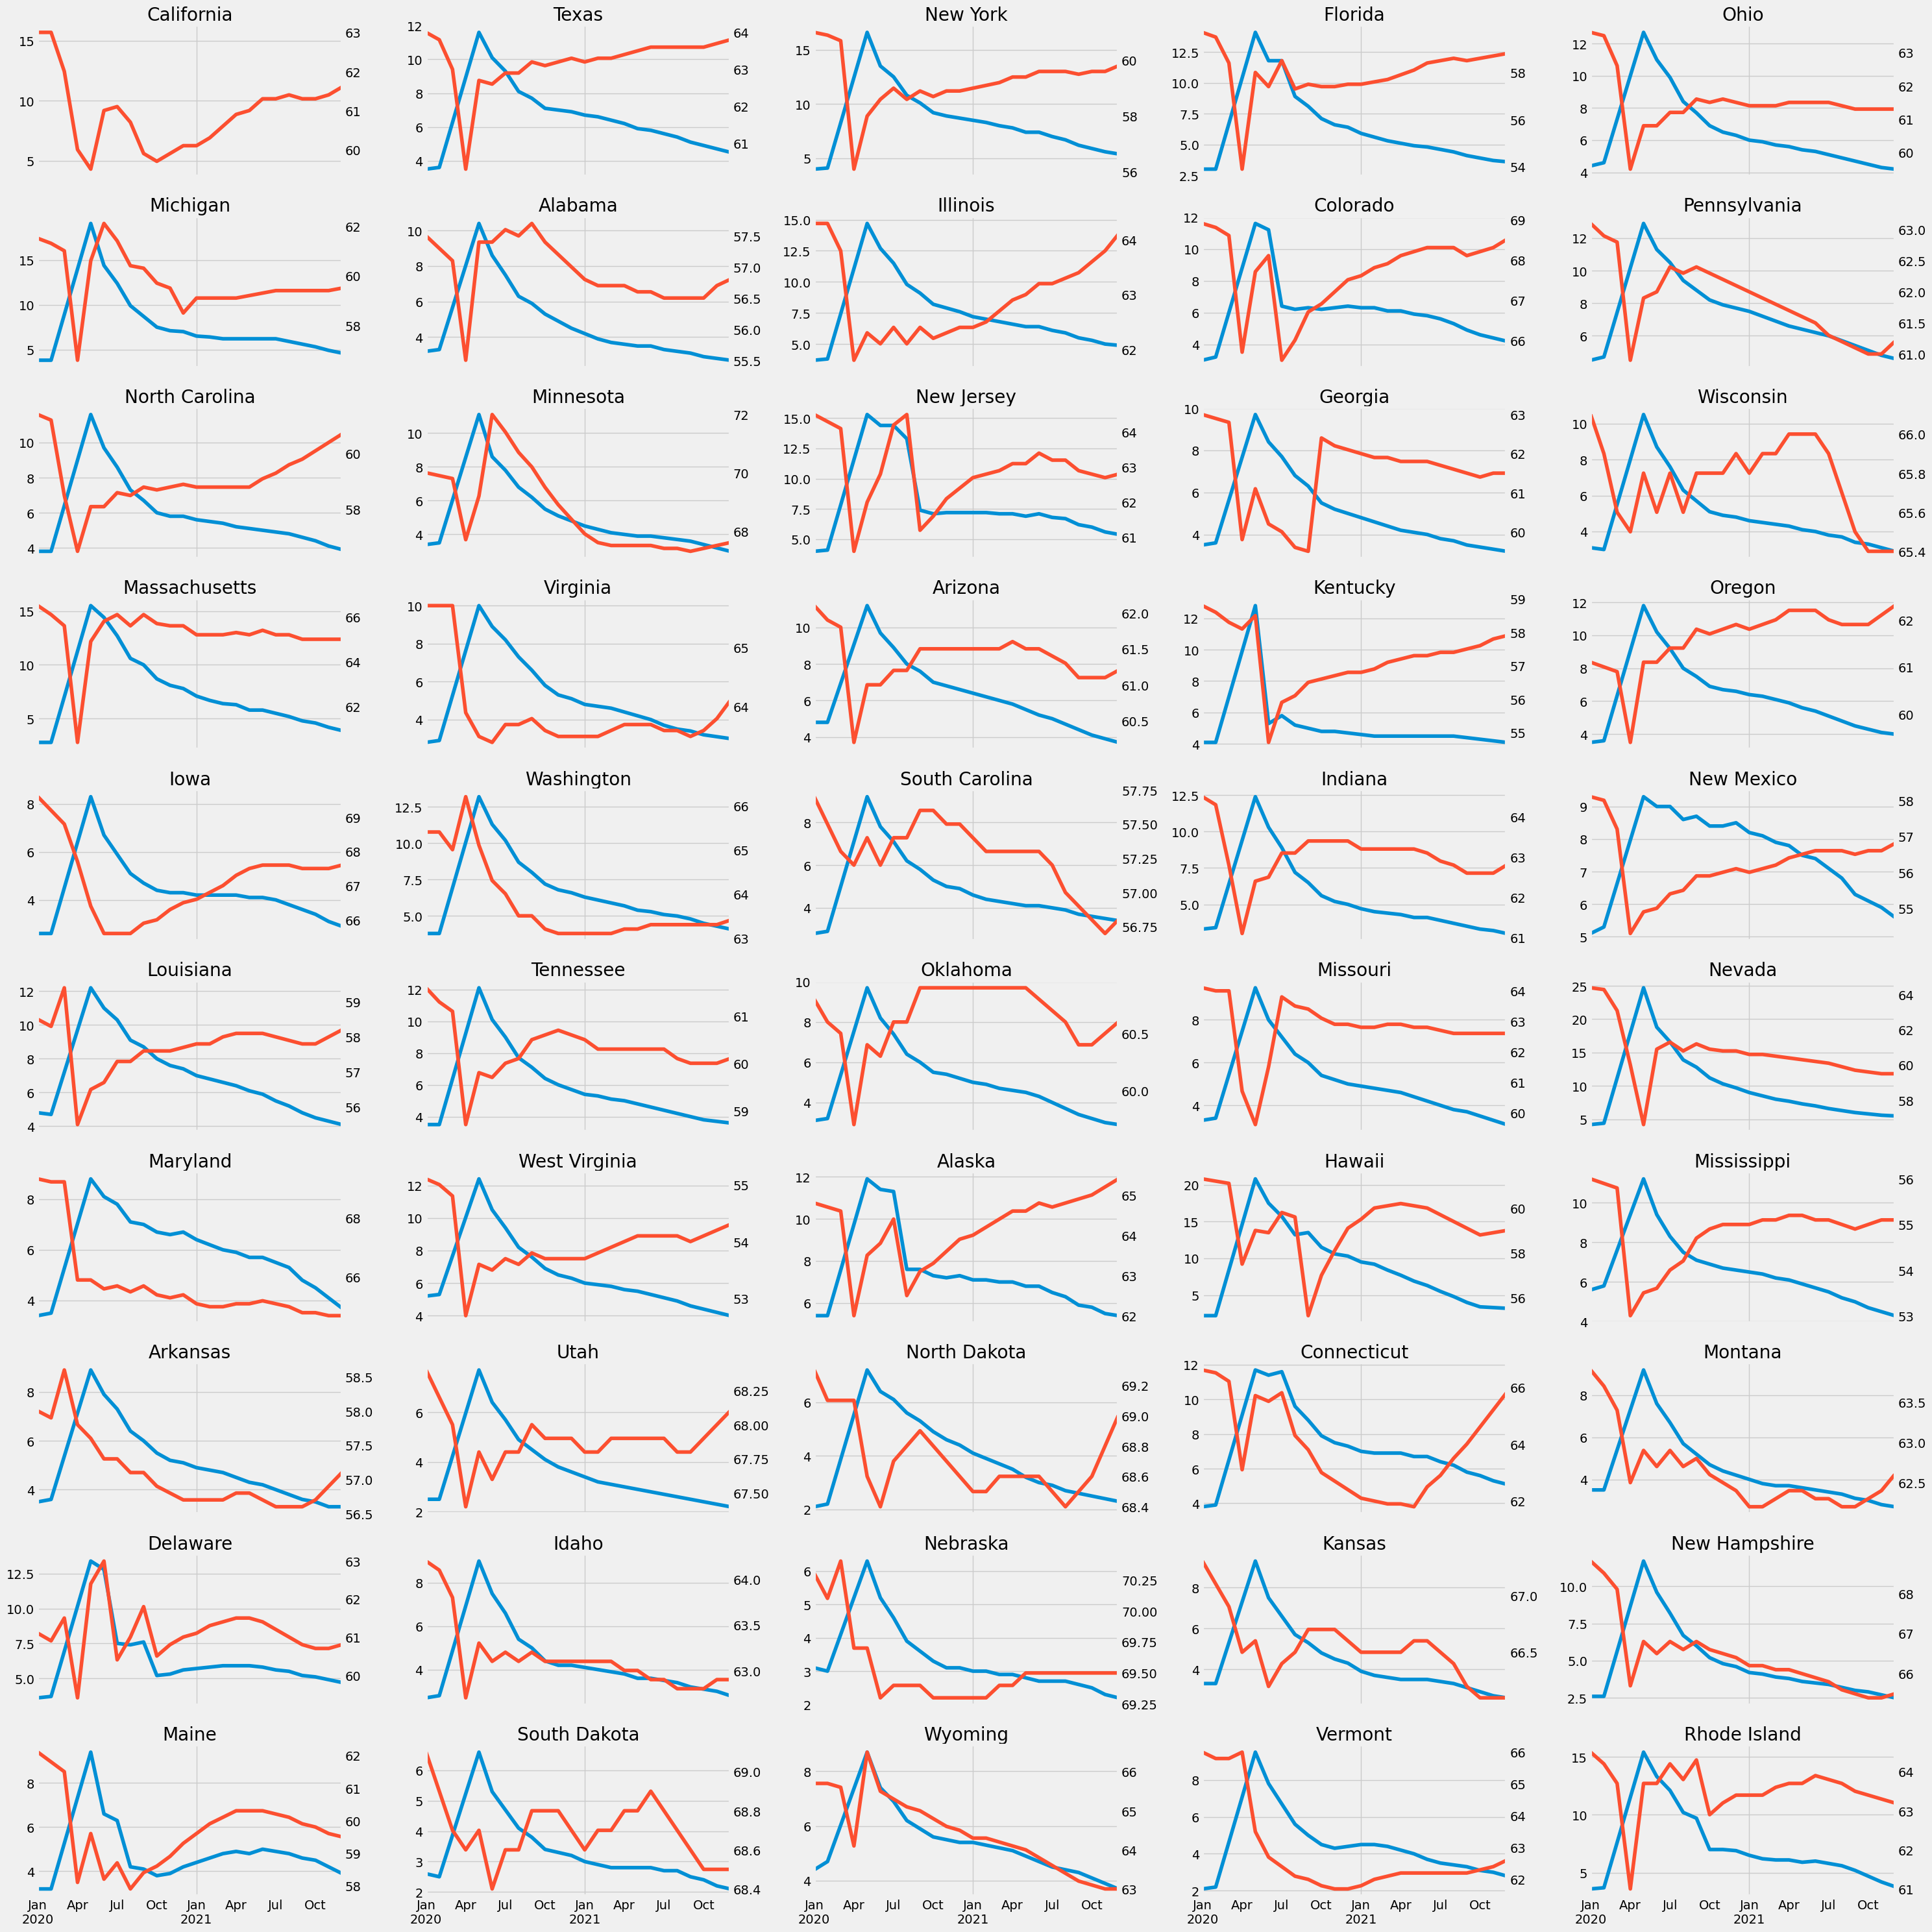

In [27]:
#For all states:

#Fixing DC - As at one place its given THE district of Columbia and at other place its given just disctrict of columbia, resulting in an error
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

#Making the graphs neat and not overlap with each other, all sharing x axis the years are constant
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

#Not plotting of DC and Peurto Rico because of differences in given data
i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1

plt.tight_layout()
plt.show()